# Fully Convolutional Network

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import random
import tensorflow as tf
import cv2
from tqdm import tqdm
import datetime
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate 
from tensorflow.keras.layers import Input, Add, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import callbacks

from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
from IPython.display import clear_output
%matplotlib inline

from IPython.display import HTML
from base64 import b64encode

## Load Dataset

### Source Dataset

In [29]:
train_img_data = tf.keras.preprocessing.image_dataset_from_directory(
    '../Fire_Dataset/train/image',
    labels=None,
    class_names=None,
    image_size=(128, 128),
    shuffle=False,
    seed=42,
    batch_size=None,
    interpolation="bilinear",
)


train_mask_data = tf.keras.preprocessing.image_dataset_from_directory(
    '../Fire_Dataset/train/mask',
    label_mode="int",
        labels=None,
    class_names=None,
    image_size=(128, 128),
    shuffle=False,
    seed=42,
    # color_mode="grayscale",
    batch_size=None,
    interpolation="bilinear",
)

val_img_data = tf.keras.preprocessing.image_dataset_from_directory(
    '../Fire_Dataset/validation/image',
    labels=None,
    class_names=None,
    image_size=(128, 128),
    shuffle=False,
    seed=42,
    batch_size=32,
    interpolation="bilinear",
)

val_mask_data = tf.keras.preprocessing.image_dataset_from_directory(
    '../Fire_Dataset/validation/mask',
    label_mode="int",

    labels=None,
    class_names=None,
    image_size=(128, 128),
    shuffle=False,
    seed=42,
    # color_mode="grayscale",
    batch_size=32,

    interpolation="bilinear",
    
)


def cast_to_int(image):
    return tf.cast(image, tf.int32)

img_train_data1 = train_img_data.map(cast_to_int)
mask_train_data1 = train_mask_data.map(cast_to_int)
img_val_data1 = val_img_data.map(cast_to_int)
mask_val_data1 = val_mask_data.map(cast_to_int)



#zip image and mask
train_data = tf.data.Dataset.zip((img_train_data1, mask_train_data1))
val_data = tf.data.Dataset.zip((img_val_data1, mask_val_data1))


#train test split
n=1000


BUFFER_SIZE = n
BATCH_SIZE = 32
train_dataset = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_data.batch(BATCH_SIZE)


Found 24925 files belonging to 1 classes.
Found 24925 files belonging to 1 classes.
Found 8307 files belonging to 1 classes.
Found 8307 files belonging to 1 classes.


In [30]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.int32, name=None), TensorSpec(shape=(None, 128, 128, 3), dtype=tf.int32, name=None))>

### Apply Transformations

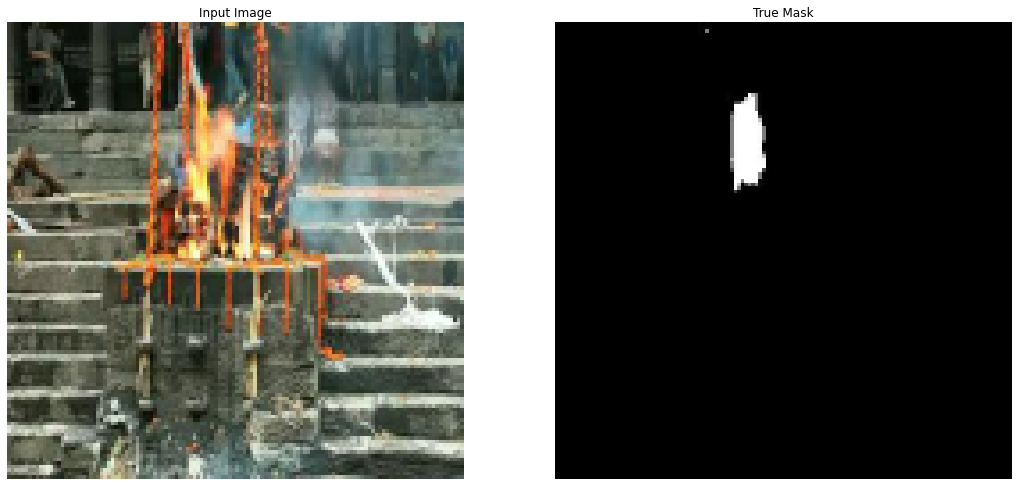

In [15]:
# Function to view the images from the directory
def display_sample(display_list):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
        
    plt.show()
    
for image, mask in train_data.take(1):
    sample_image, sample_mask = image, mask

display_sample([sample_image, sample_mask])

In [16]:
train_data.repeat()
val_data.repeat()

<RepeatDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.int32, name=None), TensorSpec(shape=(None, 128, 128, 3), dtype=tf.int32, name=None))>

## Define Network

In [17]:
# Define input shape
input_shape = (128, 128, 3)

In [18]:
# Generate a new model using the VGG network
# Input
inputs = Input(input_shape)

# # VGG network
vgg16_model = VGG16(include_top = False, weights = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', input_tensor = inputs)

# Encoder Layers
c1 = vgg16_model.get_layer("block3_pool").output         
c2 = vgg16_model.get_layer("block4_pool").output         
c3 = vgg16_model.get_layer("block5_pool").output         

# Decoder
u1 = UpSampling2D((2, 2), interpolation = 'bilinear')(c3)
d1 = Concatenate()([u1, c2])

u2 = UpSampling2D((2, 2), interpolation = 'bilinear')(d1)
d2 = Concatenate()([u2, c1])

# Output
u3 = UpSampling2D((8, 8), interpolation = 'bilinear')(d2)
outputs = Conv2D(3, 1, activation = 'sigmoid')(u3)

model = Model(inputs, outputs, name = "VGG_FCN8")

In [19]:
model.summary()

Model: "VGG_FCN8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 128, 64  36928       ['block1_conv1[0][0]']           
                                )                                                          

## Training

### Loss Function

In [20]:
m_iou = tf.keras.metrics.MeanIoU(2)
model.compile(optimizer=Adam(),
              loss=BinaryCrossentropy(),
              metrics=[m_iou])

In [21]:
tf.keras.backend.clear_session()

### Check Model

In [22]:
tf.keras.backend.set_floatx('float32')
tf.keras.backend.clear_session()

In [24]:
# Function to create a mask out of network prediction
def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    # Round to closest
    pred_mask = tf.math.round(pred_mask)
    
    # [IMG_SIZE, IMG_SIZE] -> [IMG_SIZE, IMG_SIZE, 1]
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask

# Function to show predictions
def show_predictions(dataset=None, num=1):  
    if dataset:
        # Predict and show image from input dataset
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], mask, create_mask(pred_mask)])
    else:
        # Predict and show the sample image
        inference = model.predict(sample_image)
        display_sample([sample_image[0], sample_mask[0],
                        inference[0]])
        
for image, mask in train_data.take(1):
    sample_image, sample_mask = image, mask

# show_predictions()

### Train Model

In [34]:
# Callbacks and Logs
from tensorflow.keras import callbacks


logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

callbacks = [
    callbacks.TensorBoard(logdir, histogram_freq = -1),
    callbacks.EarlyStopping(patience = 5, verbose = 1),
    callbacks.ModelCheckpoint('best_model.h5', verbose = 1, save_best_only = True)
]
        
# Set Variables
EPOCHS = 5
STEPS_PER_EPOCH = train_size // BATCH_SIZE
VALIDATION_STEPS = val_size // BATCH_SIZE

In [35]:
model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data = val_dataset,
                          validation_steps=VALIDATION_STEPS,
                          callbacks = callbacks)

Epoch 1/5


ResourceExhaustedError: Graph execution error:

2 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[32,1280,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/VGG_FCN8/conv2d/Conv2D/Conv2DBackpropFilter-0-TransposeNHWCToNCHW-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[confusion_matrix/assert_less/Assert/AssertGuard/pivot_f/_21/_55]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[32,1280,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/VGG_FCN8/conv2d/Conv2D/Conv2DBackpropFilter-0-TransposeNHWCToNCHW-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_2828]

## Testing (Test Dataset)

In [ ]:
# Function to calculate mask over image
def weighted_img(img, initial_img, α=1., β=0.5, γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

# Function to process an individual image and it's mask
def process_image_mask(image, mask):
    # Round to closest
    mask = tf.math.round(mask)
    
    # Convert to mask image
    zero_image = np.zeros_like(mask)
    mask = np.dstack((mask, zero_image, zero_image))
    mask = np.asarray(mask, np.float32)
    
    # Convert to image image
    image = np.asarray(image, np.float32)
    
    # Get the final image
    final_image = weighted_img(mask, image)

    return final_image

In [ ]:
# Function to save predictions
def save_predictions(dataset):
    # Predict and save image the from input dataset
    index = 0
    for batch_image, batch_mask in dataset:
        for image, mask in zip(batch_image, batch_mask):
            print(f"Processing image : {index}")
            pred_mask = model.predict(tf.expand_dims(image, axis = 0))
            save_sample([image, process_image_mask(image, pred_mask[0])], index)
            index += 1

# Function to save the images as a plot
def save_sample(display_list, index):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
        
    plt.savefig(f"outputs/{index}.png")
    plt.show()

In [ ]:
os.mkdir("outputs")
save_predictions(dataset['test'])

## Testing (Videos)

In [ ]:
# Function to view video
def play(filename):
    html = ''
    video = open(filename,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=1000 controls autoplay loop><source src="%s" type="video/mp4"></video>' % src 
    return HTML(html)

In [ ]:
# Function to process an individual image
def process_image(image):
    # Preprocess image
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    # Get the binary mask
    pred_mask = model.predict(np.expand_dims(image, axis = 0))
    mask = np.round_(pred_mask[0])
    
    # Convert to mask image
    zero_image = np.zeros_like(mask)
    mask = np.dstack((mask, zero_image, zero_image)) * 255
    mask = np.asarray(mask, np.uint8)
    
    # Get the final image
    final_image = weighted_img(mask, image)
    final_image = cv2.resize(final_image, (1280, 720))

    return final_image

In [ ]:
# Make a new directory
os.mkdir("videos")

### Project Video

In [ ]:
# Creating a VideoCapture object to read the video
project_video = "project_video.mp4"
original_video = cv2.VideoCapture(test_data_dir + project_video)
frame_width = int(original_video.get(3))
frame_height = int(original_video.get(4))
 
# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
fps = 60
output = cv2.VideoWriter("videos/" + project_video, fourcc, fps, (frame_width,frame_height))

# Process Video
while(original_video.isOpened()):
    ret, frame = original_video.read()

    if ret == True:
        # Write the frame into the file 'output.avi'
        output.write(process_image(frame))

    else:
        break

# When everything done, release the video capture and video write objects
original_video.release()
output.release()

In [ ]:
play("videos/" + project_video)

### Challenge Video

In [ ]:
# Creating a VideoCapture object to read the video
project_video = "challenge.mp4"
original_video = cv2.VideoCapture(test_data_dir + project_video)
frame_width = int(original_video.get(3))
frame_height = int(original_video.get(4))
 
# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
fps = 60
output = cv2.VideoWriter("videos/" + project_video, fourcc, fps, (frame_width,frame_height))

# Process Video
while(original_video.isOpened()):
    ret, frame = original_video.read()

    if ret == True:
        # Write the frame into the file 'output.avi'
        output.write(process_image(frame))

    else:
        break

# When everything done, release the video capture and video write objects
original_video.release()
output.release()

In [ ]:
play("videos/" + project_video)

### Challenge Video 2

In [ ]:
# Creating a VideoCapture object to read the video
project_video = "challenge_video.mp4"
original_video = cv2.VideoCapture(test_data_dir + project_video)
frame_width = int(original_video.get(3))
frame_height = int(original_video.get(4))
 
# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
fps = 60
output = cv2.VideoWriter("videos/" + project_video, fourcc, fps, (frame_width,frame_height))

# Process Video
while(original_video.isOpened()):
    ret, frame = original_video.read()

    if ret == True:
        # Write the frame into the file 'output.avi'
        output.write(process_image(frame))

    else:
        break

# When everything done, release the video capture and video write objects
original_video.release()
output.release()

In [ ]:
play("videos/" + project_video)

### Harder Challenge Video

In [ ]:
# Creating a VideoCapture object to read the video
project_video = "harder_challenge_video.mp4"
original_video = cv2.VideoCapture(test_data_dir + project_video)
frame_width = int(original_video.get(3))
frame_height = int(original_video.get(4))
 
# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
fps = 60
output = cv2.VideoWriter("videos/" + project_video, fourcc, fps, (frame_width,frame_height))

# Process Video
while(original_video.isOpened()):
    ret, frame = original_video.read()

    if ret == True:
        # Write the frame into the file 'output.avi'
        output.write(process_image(frame))

    else:
        break

# When everything done, release the video capture and video write objects
original_video.release()
output.release()

In [ ]:
play("videos/" + project_video)

## References

- [Kitti Dataset Processing](http://ronny.rest/blog/post_2017_09_06_kitti_road_data/)
- [Image Segmentation on Keras](https://yann-leguilly.gitlab.io/post/2019-12-14-tensorflow-tfdata-segmentation/)